In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#%matplotlib inline

from IPython.core.pylabtools import figsize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
figsize(10, 8)
sns.set()



In [2]:
files = ['fileViews',
         'premium_cancellations',
         'premium_payments',
         'questions',
         'sessions',
         'students',
         'subjects'
         ]

datasets = {}
for file in files:
    datasets[file] = pd.read_csv(f"../data/processed/{file}.csv")#,parse_dates=[1,2],index_col=[0])
    print(f'*********{file}***********')
    print(datasets[file].shape)
    print(datasets[file].head())
    print("____________\n\n")

/home/ahgora/projetos/pd/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


*********fileViews***********
(3028988, 4)
  StudentId                                           FileName  \
0  12970655  Exercicios Resolvidos do Halliday sobre Rotaçã...   
1  12970655  Exercicios Resolvidos do Halliday sobre Rotaçã...   
2  12970655                                          CALCULO I   
3  12970655                                          CALCULO I   
4  12970655                                          CALCULO I   

                     ViewDate Studentclient  
0  2017-02-23 10:46:03.047000       Website  
1  2017-02-23 10:46:12.370000       Website  
2  2017-05-25 22:39:48.000000       Website  
3  2017-05-25 22:40:36.000000       Website  
4  2017-05-25 22:43:16.000000       Website  
____________


*********premium_cancellations***********
(844, 2)
   StudentId            CancellationDate
0   34129668  2016-05-05 19:08:31.937000
1   34129668  2016-05-05 22:48:20.830000
2   82394932  2016-05-20 22:37:21.117000
3   82942835  2016-05-31 13:44:55.307000
4   85382416 

---
## Segmentação de Usuários
A partir dos dados de estudantes e informações de uso da plataforma
montaremos uma nova base de dados com o objetivo de agrupar os usuários por similaridade.
### Features:

- StudentId
- registered_time(days)
- usage_weekly_count(com
session)
- usage_weekly_mean(com
session)
- count_sessions
- rate - sessions(qtd / tempobase)
- count_file_view
- Rate - fileview
- count_question
- rate - question
- Região - ohe - OK
- Estado - ohe - OK
- Device_type
- count_payment
- count_payment_mensal
- count_paymant_anual
- count_cancellation
- count_subject

In [3]:
df_abt = pd.read_csv(f"../data/processed/abt_segmentation.csv")
df_abt.loc[df_abt.State=="0",'State'] = "NA"
df_abt.loc[df_abt.City=="0",'City'] = "NA"
df_abt.head()

,Id,UniversityName,CourseName,City,State,registered_time,usage_weekly_count,usage_weekly_mean,session_count,session_rate,...,question_count,question_rate,region,mobile,desktop,payment_total,payment_monthly,payment_yearly,cancelation_count,subject_count
0,12970655,PUC-RIO,Administração,NA,Rio de Janeiro,2200,46.0,2.369565,109,0.049545,...,6.0,0.002727,sudeste,1,1,20.0,18.0,2.0,0.0,6.0
1,59873654,UFF,Direito do Trabalho e Segurança Social,Rio de Janeiro,Rio de Janeiro,2103,10.0,2.100000,21,0.009986,...,0.0,0.000000,sudeste,0,1,0.0,0.0,0.0,0.0,5.0
2,3664695,UNB,Enfermagem,NA,Distrito Federal,2096,4.0,2.000000,8,0.003817,...,0.0,0.000000,centro_oeste,0,1,0.0,0.0,0.0,0.0,5.0
3,15207697,UERJ,Engenharia de Produção Mecânica,Resende,Rio de Janeiro,2101,3.0,1.333333,4,0.001904,...,0.0,0.000000,sudeste,0,1,0.0,0.0,0.0,0.0,5.0
4,36988693,UFU,Engenharia Elétrica,NA,NA,2061,21.0,1.857143,39,0.018923,...,0.0,0.000000,na,0,1,0.0,0.0,0.0,0.0,5.0


In [4]:
categorical = ['CourseName']
df_abt_categorical = df_abt[categorical]
df_abt_categorical.index = df_abt.index
ohe = pd.get_dummies(df_abt_categorical)
df_train_full = pd.concat([df_abt,ohe],axis=1)

df_train_full.drop(categorical+['UniversityName','State','City',"region"], axis=1, inplace=True)
df_train_full.index =df_train_full["Id"]
df_train_full.head()
### Clusterização com Kmeans


,Id,registered_time,usage_weekly_count,usage_weekly_mean,session_count,session_rate,fileview_count,fileview_rate,question_count,question_rate,...,CourseName_Transporte Terrestre,CourseName_Turismo,CourseName_Têxtil e Moda,CourseName_Urbanismo,CourseName_Vendas em Atacado e Varejo,CourseName_Veterinária / Medicina Veterinária,CourseName_Visagismo e Terapia Capilar,CourseName_Viticultura e Enologia,CourseName_Zoologia,CourseName_Zootecnia
Id,,,,,,,,,,,,,,,,,,,,,
12970655,12970655,2200,46.0,2.369565,109,0.049545,45.0,0.020455,6.0,0.002727,...,0,0,0,0,0,0,0,0,0,0
59873654,59873654,2103,10.0,2.100000,21,0.009986,19.0,0.009035,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3664695,3664695,2096,4.0,2.000000,8,0.003817,7.0,0.003340,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
15207697,15207697,2101,3.0,1.333333,4,0.001904,5.0,0.002380,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
36988693,36988693,2061,21.0,1.857143,39,0.018923,46.0,0.022319,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [5]:
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)*2 + (x2 - x1)*2)
        distances.append(numerator/denominator)

    return distances.index(max(distances)) + 2


def calculate_wcss(data):
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [6]:
df_classification = df_train_full.drop('Id',axis=1)
sc = StandardScaler()
df_classification_scaled = sc.fit_transform(df_classification)

---
### calculando a quantidade ótima de clusters
```
sum_of_squares = calculate_wcss(df_classification_scaled)
n = optimal_number_of_clusters(sum_of_squares)
print('numero ótimo de clusters: {}'.format(n))
```

In [7]:
n=2
kmeans = KMeans(n_clusters=n, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0)
kmeans.fit(df_classification_scaled)
clusters = kmeans.fit_predict(df_classification_scaled).copy()

clusters_list = list(clusters)

x = Counter(clusters_list).keys()
y = Counter(clusters_list).values()
print('número de pessoas por grupo: {}'.format(y))

columns_names=df_classification.columns
df_segmented_students = pd.DataFrame(df_classification, columns = columns_names, index = df_classification.index)
df_segmented_students['id_cluster'] = clusters
df_segmented_students['StudentId'] = df_train_full.index

número de pessoas por grupo: dict_values([4030, 55976])


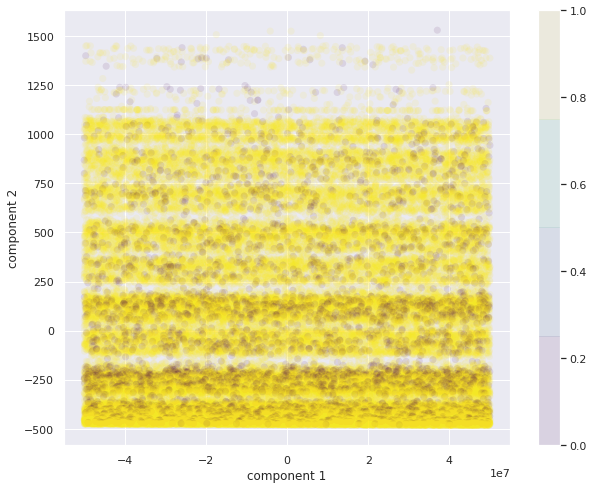

In [8]:
pca = PCA(n_components=2)
pca.fit(df_classification)
X_pca = pca.transform(df_classification)

plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=clusters, s=50,edgecolor='none', alpha=0.1,
            cmap=plt.cm.get_cmap('viridis', 4))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

```
from pandas_profiling import ProfileReport
profile = ProfileReport(df_segmented_students, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()
```

In [9]:
target = df_segmented_students['id_cluster']
X = df_segmented_students.drop(['id_cluster','StudentId'],axis=1)
X.columns



Index(['registered_time', 'usage_weekly_count', 'usage_weekly_mean',
       'session_count', 'session_rate', 'fileview_count', 'fileview_rate',
       'question_count', 'question_rate', 'mobile',
       ...
       'CourseName_Transporte Terrestre', 'CourseName_Turismo',
       'CourseName_Têxtil e Moda', 'CourseName_Urbanismo',
       'CourseName_Vendas em Atacado e Varejo',
       'CourseName_Veterinária / Medicina Veterinária',
       'CourseName_Visagismo e Terapia Capilar',
       'CourseName_Viticultura e Enologia', 'CourseName_Zoologia',
       'CourseName_Zootecnia'],
      dtype='object', length=490)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, target, test_size = 0.8, random_state = 42)

rf = RandomForestClassifier(n_estimators = 200,
                               n_jobs = -1,
                                class_weight='balanced_subsample',
                               random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

1.0

In [11]:
rf.score(X_valid, y_valid)

0.9889178210603062

<AxesSubplot:>

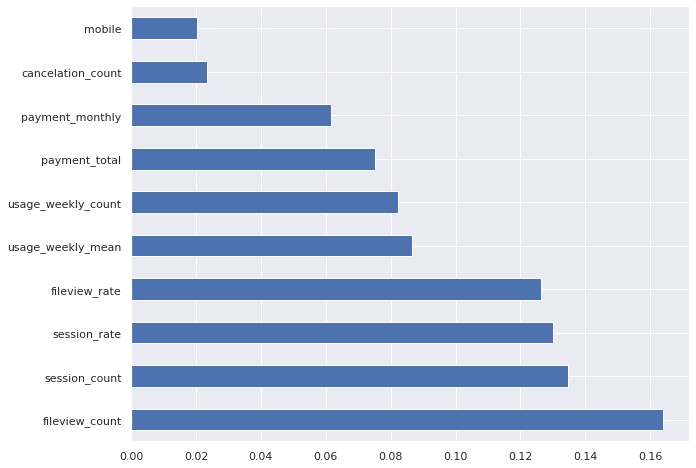

In [12]:
rf.feature_importances_
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [44]:
df_features = feat_importances.nlargest(10).reset_index()
df_features.columns = ['feature','importance']
list(df_features.feature)
#df_features

['fileview_count',
 'session_count',
 'session_rate',
 'fileview_rate',
 'usage_weekly_mean',
 'usage_weekly_count',
 'payment_total',
 'payment_monthly',
 'cancelation_count',
 'mobile']

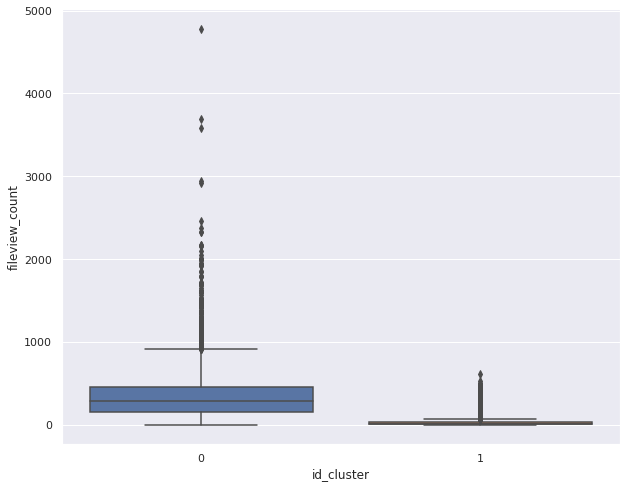

In [14]:
best_features = ["id_cluster"] + list(df_features.feature.values)
#sns.boxplot(df_segmented_students[['fileview_count','session_count','payment_total']])
base = df_segmented_students[best_features]
base=base
#sns.set_theme(style="ticks", palette="pastel")
ax = sns.boxplot(data=base, x="id_cluster",y='fileview_count')

<AxesSubplot:xlabel='id_cluster', ylabel='session_count'>

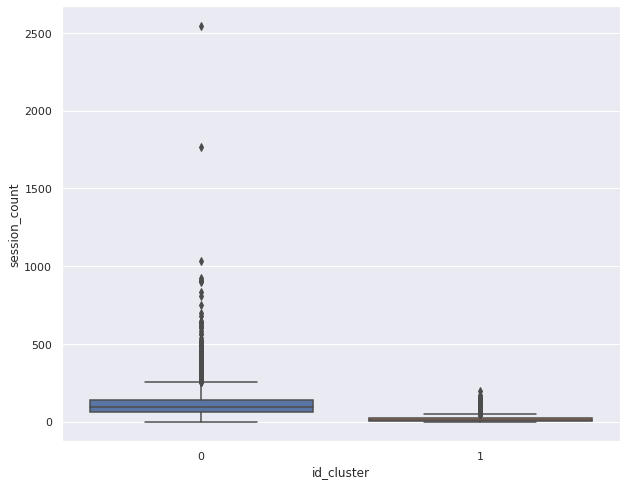

In [15]:
sns.boxplot(data=base, x="id_cluster",y='session_count' )

<AxesSubplot:xlabel='id_cluster', ylabel='payment_total'>

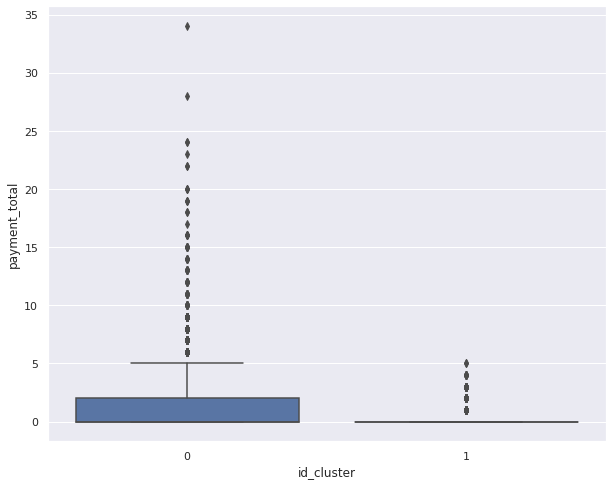

In [16]:
sns.boxplot(data=base, x="id_cluster",y='payment_total')

<AxesSubplot:xlabel='id_cluster', ylabel='session_rate'>

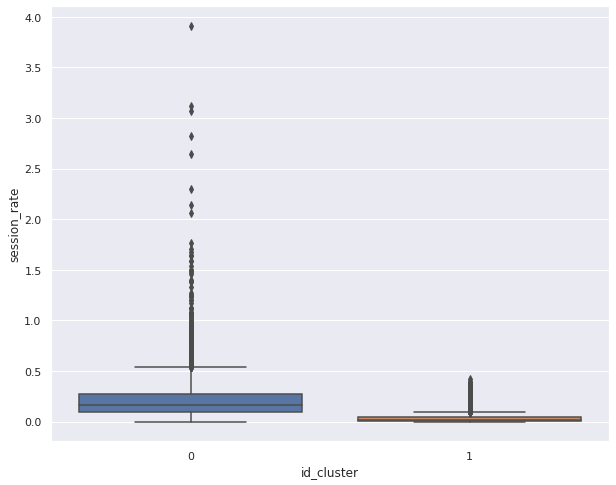

In [17]:
sns.boxplot(data=base, x="id_cluster",y='session_rate')

<AxesSubplot:xlabel='id_cluster', ylabel='fileview_rate'>

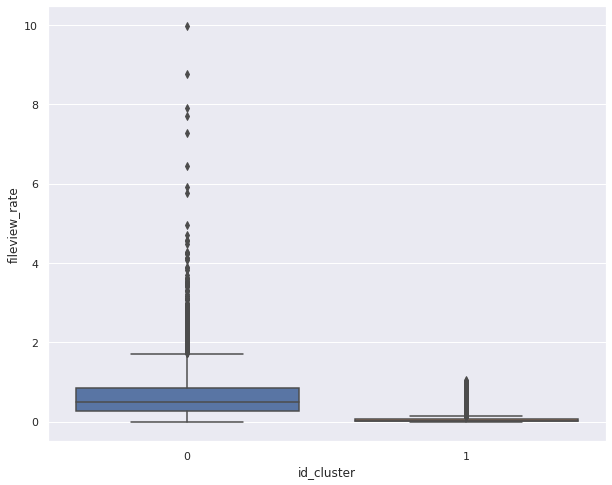

In [18]:
sns.boxplot(data=base, x="id_cluster",y='fileview_rate')

<AxesSubplot:xlabel='id_cluster', ylabel='usage_weekly_count'>

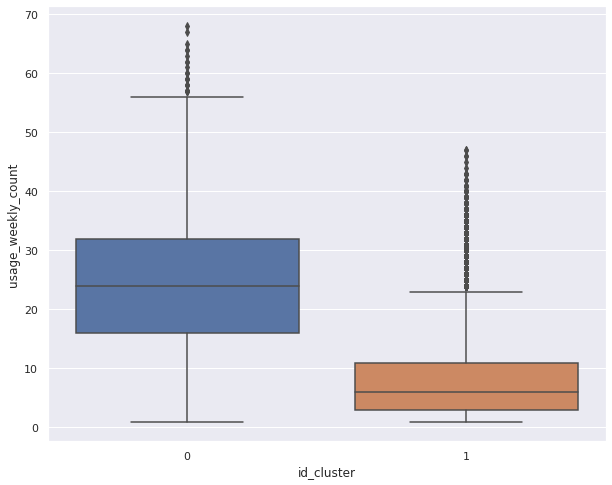

In [19]:
sns.boxplot(data=base, x="id_cluster",y='usage_weekly_count')

In [20]:
base.loc[base.id_cluster==0].describe().T

,count,mean,std,min,25%,50%,75%,max
id_cluster,4030.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fileview_count,4030.0,354.079404,322.053234,0.000000,152.000000,279.000000,454.000000,4775.000000
session_count,4030.0,113.487345,99.431752,1.000000,60.000000,94.000000,138.000000,2543.000000
session_rate,4030.0,0.216609,0.221801,0.000635,0.091838,0.161280,0.269913,3.907080
fileview_rate,4030.0,0.652395,0.663405,0.000000,0.256910,0.490489,0.840383,9.968685
usage_weekly_mean,4030.0,5.218584,11.585614,1.000000,3.000000,3.857143,5.217098,610.000000
usage_weekly_count,4030.0,24.589826,11.654143,1.000000,16.000000,24.000000,32.000000,68.000000
payment_total,4030.0,1.661042,3.038717,0.000000,0.000000,0.000000,2.000000,34.000000
payment_monthly,4030.0,1.589578,3.050870,0.000000,0.000000,0.000000,2.000000,34.000000
cancelation_count,4030.0,0.178660,0.434137,0.000000,0.000000,0.000000,0.000000,3.000000


In [21]:
base.loc[base.id_cluster==1].describe().T


,count,mean,std,min,25%,50%,75%,max
id_cluster,55976.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fileview_count,55976.0,28.620177,47.622885,0.000000,4.000000,11.000000,30.000000,607.000000
session_count,55976.0,16.829248,18.468794,1.000000,4.000000,10.000000,23.000000,196.000000
session_rate,55976.0,0.032617,0.038278,0.000456,0.008424,0.019231,0.042079,0.421053
fileview_rate,55976.0,0.053830,0.090801,0.000000,0.008102,0.021326,0.056049,1.049107
usage_weekly_mean,55976.0,1.943345,1.328225,1.000000,1.200000,1.666667,2.250000,51.000000
usage_weekly_count,55976.0,7.926665,6.807995,1.000000,3.000000,6.000000,11.000000,47.000000
payment_total,55976.0,0.010540,0.139915,0.000000,0.000000,0.000000,0.000000,5.000000
payment_monthly,55976.0,0.009861,0.137518,0.000000,0.000000,0.000000,0.000000,5.000000
cancelation_count,55976.0,0.002215,0.047015,0.000000,0.000000,0.000000,0.000000,1.000000


In [22]:
# não usa desktop
df_segmented_students.loc[df_segmented_students['desktop'] == 0].id_cluster.value_counts()

1    9308
0     342
Name: id_cluster, dtype: int64

In [23]:
# não usa mobile
df_segmented_students.loc[df_segmented_students['mobile'] == 0].id_cluster.value_counts()

1    40473
0     1513
Name: id_cluster, dtype: int64

In [24]:
#  usa mobile e desktop
df_segmented_students.loc[(df_segmented_students['mobile']) == 1 & (df_segmented_students['desktop']==1)].id_cluster.value_counts()

1    17051
0     2427
Name: id_cluster, dtype: int64

In [25]:
#taxa de session
df_segmented_students.loc[df_segmented_students.session_count > 10].id_cluster.value_counts()

1    27536
0     3969
Name: id_cluster, dtype: int64

In [26]:
df_segmented_students.loc[df_segmented_students.session_count > 23].id_cluster.value_counts()

1    13715
0     3818
Name: id_cluster, dtype: int64

<AxesSubplot:>

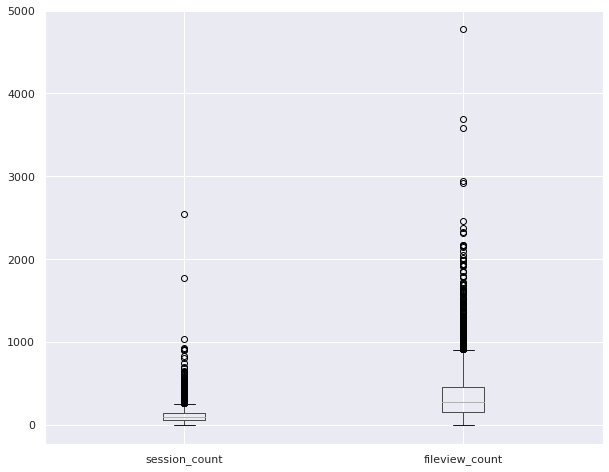

In [27]:
#distribuição de fileview e session por perfil
df_segmented_students.loc[ (df_segmented_students.id_cluster==0) ,['session_count','fileview_count'] ].boxplot()

<AxesSubplot:>

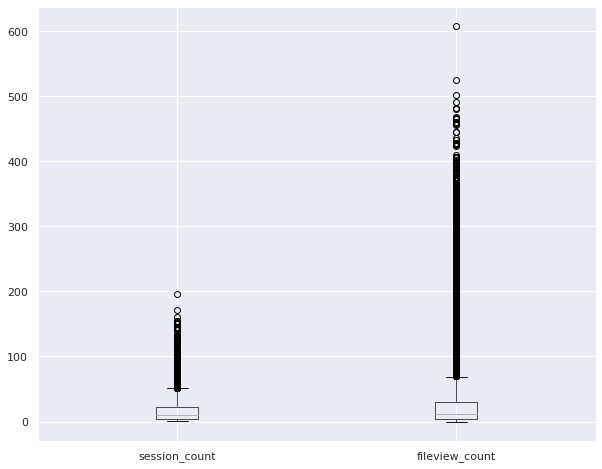

In [28]:
df_segmented_students.loc[ (df_segmented_students.id_cluster==1),['session_count','fileview_count'] ].boxplot()

In [29]:
df_segmented_students.loc[ (df_segmented_students.id_cluster==0) & (df_segmented_students.fileview_count < 1000)].session_count.count()

3868

In [30]:
df_segmented_students.loc[(df_segmented_students.fileview_count > 10)  & (df_segmented_students.fileview_count < 1000)].id_cluster.value_counts()


1    29068
0     3810
Name: id_cluster, dtype: int64

In [31]:
#Não pagantes com alto uso(TIPO 1) (possibilidade de conversão)
df_segmented_students.loc[df_segmented_students.id_cluster==0].payment_total.value_counts()

0.0     2454
1.0      396
2.0      284
7.0      195
3.0      174
4.0      121
8.0      116
5.0       98
6.0       69
9.0       45
10.0      12
11.0      12
12.0       9
13.0       9
15.0       8
14.0       7
16.0       5
19.0       3
20.0       3
18.0       2
22.0       2
24.0       2
28.0       1
34.0       1
17.0       1
23.0       1
Name: payment_total, dtype: int64

In [32]:
#pagantes com baixo uso(TIPO 2) (possibilidade de churn)
df_segmented_students.loc[df_segmented_students.id_cluster==1].payment_total.value_counts()



0.0    55568
1.0      283
2.0       83
3.0       29
4.0       11
5.0        2
Name: payment_total, dtype: int64

In [33]:
df_segmented_students.loc[df_segmented_students.id_cluster==1].cancelation_count.value_counts()

0.0    55852
1.0      124
Name: cancelation_count, dtype: int64

In [34]:
df_segmented_students.loc[df_segmented_students.id_cluster==0].cancelation_count.value_counts()

0.0    3386
1.0     576
2.0      60
3.0       8
Name: cancelation_count, dtype: int64

Quantidade de usuários pagantes com e sem cancelamento

In [35]:
# Grupo 1 que nunca cancelaram e com algum cancelamento
(
df_segmented_students.loc[
    (df_segmented_students.id_cluster==1)&
    (df_segmented_students.cancelation_count == 0)&
    (df_segmented_students.payment_total > 0)
].shape[0],
df_segmented_students.loc[
    (df_segmented_students.id_cluster==1)&
    (df_segmented_students.cancelation_count > 0)&
    (df_segmented_students.payment_total > 0)
].shape[0]
    )

(310, 98)

In [36]:
# Grupo 0 que nunca cancelaram e com algum cancelamento
(
df_segmented_students.loc[
    (df_segmented_students.id_cluster==0)&
    (df_segmented_students.cancelation_count == 0)&
    (df_segmented_students.payment_total > 0)
].shape[0],
df_segmented_students.loc[
    (df_segmented_students.id_cluster==0)&
    (df_segmented_students.cancelation_count > 0)&
    (df_segmented_students.payment_total > 0)
].shape[0]
    )

(948, 628)

---
### Tempo desde o cadastro por tipo de perfil ( em dias )

In [37]:
(
df_segmented_students.loc[
    (df_segmented_students.id_cluster==1)
].registered_time.agg([ 'min','max','mean','std','median']),
df_segmented_students.loc[
    (df_segmented_students.id_cluster==0)
].registered_time.agg([ 'min','max','mean','std','median'])
    )

(min        189.000000
 max       2195.000000
 mean       666.203694
 std        483.239238
 median     451.000000
 Name: registered_time, dtype: float64,
 min        189.000000
 max       2200.000000
 mean       690.250620
 std        424.157302
 median     577.000000
 Name: registered_time, dtype: float64)

---
### Uso no últimos meses
Usuários com sessões por TIPO

In [38]:
sessions = datasets.get('sessions')
start_date = pd.to_datetime('2018-05-07 05:01:51')
sessions.SessionStartTime = sessions.SessionStartTime.astype('datetime64[ns]')
last_month_active_users = sessions.loc[sessions.SessionStartTime > start_date ].StudentId.unique()
#datasets.get('sessions').SessionStartTime.max()

In [39]:
#sessions.loc[sessions.StudentId == 12970655 ].SessionStartTime.max()
last_month_active_users

array([12970655, 59873654, 36988693, ..., 11844170, 81383037, 69759595])

In [40]:
(
df_segmented_students.loc[
    (df_segmented_students.id_cluster==1)&
    (df_segmented_students.StudentId.isin(last_month_active_users))
].StudentId.agg([ 'count']),
   df_segmented_students.loc[
    (df_segmented_students.id_cluster==0)&
    (df_segmented_students.StudentId.isin(last_month_active_users))
].StudentId.agg([ 'count'])
    )

(count    18201
 Name: StudentId, dtype: int64,
 count    3156
 Name: StudentId, dtype: int64)

In [41]:
#Não pagantes com alto uso(TIPO 1) (possibilidade de conversão)
df_segmented_students.loc[
    (df_segmented_students.id_cluster==0)&
    (df_segmented_students.StudentId.isin(last_month_active_users))
].payment_total.value_counts()

0.0     1968
1.0      334
2.0      208
7.0      156
3.0      122
8.0       90
4.0       85
5.0       69
6.0       46
9.0       29
13.0       7
15.0       7
12.0       6
11.0       6
10.0       5
14.0       4
18.0       2
19.0       2
22.0       2
24.0       2
20.0       2
16.0       1
34.0       1
17.0       1
28.0       1
Name: payment_total, dtype: int64

In [42]:
#pagantes com baixo uso(TIPO 2) (possibilidade de churn)
df_segmented_students.loc[
    (df_segmented_students.id_cluster==1)&
    (df_segmented_students.StudentId.isin(last_month_active_users))
].payment_total.value_counts()



0.0    17952
1.0      189
2.0       43
3.0       14
4.0        3
Name: payment_total, dtype: int64

////////////////////////////////////////////////////////////////////

---
## Questão 4:
Ainda considerando os dados passados no teste, como você segmentaria os
usuários da Passei Direto e quais recomendações, em termos de negócio, você forneceria para
as diversas áreas do PD (por exemplo: as áreas de Marketing, Cliente e Financeiro, etc.)?
Apresentar o código de como seria feita a classificação.

* Marketing:
    * Anúncios em universidade que possuam curso de direito com usuários da ferramenta
    nas cidades onde já tem bons resultados.
    * Redes de ensino com abrangência nacional talvez sejam mais fáceis por conta do material didático comum.

In [43]:
['MACKENZIE', 'PUC-MINAS', 'FMU', 'UCAM', 'UNINOVE', 'PUC-SP',
       'UNICAP', 'UNIVERSO', 'UERJ', 'UNIFOR']

['MACKENZIE',
 'PUC-MINAS',
 'FMU',
 'UCAM',
 'UNINOVE',
 'PUC-SP',
 'UNICAP',
 'UNIVERSO',
 'UERJ',
 'UNIFOR']

* Novos Negócios e Growth
    * Programa de afiliados
    * Diretório Academicos (DA) com 'indicação premiada' - reverter em melhorias ou monetizar por meio de link de afiliado.

* Sucesso do cliente
    * Estudantes pagantes do grupo de pouco uso tem maior chance de sair
    * Estudantes não pagantes